# **Deep Hallucination Classification**
## Classify images hallucinated by deep generative models
### **Imports**
All the imports are defined here

In [46]:
from __future__ import print_function, division
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
import torch.nn.functional as F
import math
from collections import OrderedDict
from PIL import *

CUDA_LAUNCH_BLOCKING=1

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [3]:
# Mount to drive
drive.mount('/content/gdrive', force_remount=True)
data_dir_drive ='/content/gdrive/My Drive/Colab Notebooks/Deep/'
data_dir ='/content' # When read from unziped file

Mounted at /content/gdrive


### **Unzip data**

In [4]:
import time

start = time.time()

#!unzip -q '/content/gdrive/My Drive/Colab Notebooks/Deep/test.zip' -d '/content/gdrive/My Drive/Colab Notebooks/Deep/data'
#!unzip -q '/content/gdrive/My Drive/Colab Notebooks/Deep/data.zip' -d '/content/gdrive/My Drive/Colab Notebooks/Deep/data'

print('Took', (time.time() - start), ' secundes to unzip')

Took 5.602836608886719e-05  secundes to unzip


In [5]:
! ls '/content/gdrive/My Drive/Colab Notebooks/Deep/data/data'

train  validation


In [6]:
TRAIN = 'train' #folder name
VAL = 'validation' #folder name
TEST = 'test' #folder name
BATCHSIZE = 256

### **Neural Net Definition**
We will use a standard convolutional neural network(VGG16)


In [62]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = []
        in_channels = 3 #color image
        for t in [64, 64, 'MaxP', 128, 128, 'MaxP', 256, 256, 256, 'MaxP', 512, 512, 512, 'MaxP', 512, 512, 512, 'MaxP']: #VGG16:
            if t == 'MaxP':
                self.features.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.features += [nn.Conv2d(in_channels, t, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(t),
                                    nn.ReLU(inplace=True)]
                in_channels = t 
        self.features.append(nn.AvgPool2d(kernel_size=1, stride=1))
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Linear(512, 8)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1) #vector transformation
        out = self.classifier(out)
        return out

In [63]:
net = VGG()

In [ ]:
#calculate mean and std for train data
#train_set = datasets.ImageFolder(
#        os.path.join(data_dir_drive + 'data/data', TRAIN), 
#        transform=transforms.Compose([transforms.ToTensor()]))
#
#loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
#data = next(iter(loader))
#
#print(data[0].view(len(data[0]), 3, -1).mean(2).sum(0) / len(data[0]))
#print(data[0].view(len(data[0]), 3, -1).std(2).sum(0) / len(data[0]))

### **Data augentation**

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4092, 0.4594, 0.4538), (0.2346, 0.2431, 0.2467))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4092, 0.4594, 0.4538), (0.2346, 0.2431, 0.2467))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4092, 0.4594, 0.4538), (0.2346, 0.2431, 0.2467))
])

==> Preparing data..


### **Dataset loader**
**Using Image Folder Dataset**

In [27]:
image_datasets = {
    TRAIN: datasets.ImageFolder(
        os.path.join(data_dir_drive + 'data/data', TRAIN), 
        transform=transform_train
    ),
    VAL: datasets.ImageFolder(
        os.path.join(data_dir_drive + 'data/data', VAL), 
        transform=transform_val
    )
}

trainloader = torch.utils.data.DataLoader(
            image_datasets[TRAIN], batch_size=BATCHSIZE,
            shuffle=True, num_workers=BATCHSIZE)

valloader = torch.utils.data.DataLoader(
            image_datasets[VAL], batch_size=BATCHSIZE,
            shuffle=True, num_workers=BATCHSIZE)


dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
total = dataset_sizes[TRAIN] + dataset_sizes[VAL]# + dataset_sizes[TEST]

for x in [TRAIN, VAL]: 
    print("Loaded {} images under {} ({}%)".format(dataset_sizes[x], x, dataset_sizes[x] * 100 / total))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 30001 images under train (85.71469386588954%)
Loaded 5000 images under validation (14.285306134110455%)
Classes: 
['0', '1', '2', '3', '4', '5', '6', '7']


### **Visualising some of the data**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


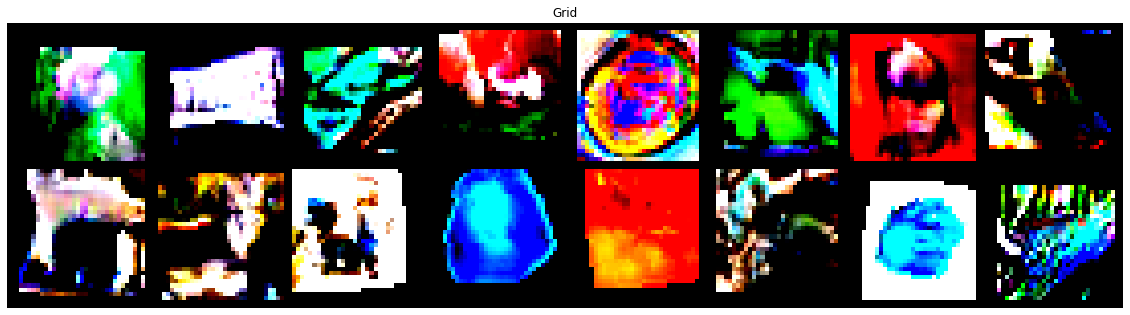

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title='Grid') #[class_names[x] for x in classes]

# Get a batch of training data
inputs, classes = next(iter(torch.utils.data.DataLoader(
            image_datasets[TRAIN], batch_size=16,
            shuffle=True, num_workers=16)))
show_databatch(inputs, classes)

In [28]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss() #classifiaction
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [43]:
accuracies = {x: [] for x in [TRAIN, VAL]}
losses = {x: [] for x in [TRAIN, VAL]}
best_model_wts = copy.deepcopy(net.state_dict())

In [41]:
# Training
def train(net, epoch):
    print("TRAINING")
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        with torch.no_grad():
            if use_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward() #calculate the gradients
        optimizer.step() #take a step down the gradient

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        del inputs, targets, outputs, predicted
        torch.cuda.empty_cache()

    print("Avg loss (train): {:.4f}".format(train_loss / total))
    print("Avg acc (train): {:.4f}".format(100.*correct/total))
    return net

    

def test(net, epoch = 0):
    global best_acc
    print("MESURE ACCURACY ON TRAIN AND VALIDATION")
    net.train(False)
    net.eval()

    loss_train = 0
    acc_train = 0
    num_exam_train = 0
    with torch.no_grad(): #I do not touch the HYPOTHESIS
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            if use_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            loss_train += loss.item()
            _, predicted = outputs.max(1)
            num_exam_train += targets.size(0)
            acc_train += predicted.eq(targets).sum().item()

            del inputs, targets, outputs, predicted
            torch.cuda.empty_cache()

    avg_loss_train = loss_train / num_exam_train
    avg_acc_train = float(acc_train) * 100 / num_exam_train
    accuracies[TRAIN].append(avg_acc_train)
    losses[TRAIN].append(avg_loss_train)

    loss_val = 0
    acc_val = 0
    num_exam_val = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            if use_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            loss_val += loss.item()
            _, predicted = outputs.max(1)
            num_exam_val += targets.size(0)
            acc_val += predicted.eq(targets).sum().item()

            del inputs, targets, outputs, predicted
            torch.cuda.empty_cache()

    avg_loss_val = loss_val / num_exam_val
    avg_acc_val = float(acc_val) * 100 / num_exam_val
    accuracies[VAL].append(avg_acc_val)
    losses[VAL].append(avg_loss_val)

    print("Epoch {} result: ".format(epoch + 1))
    print("Avg loss (train): {:.4f}".format(avg_loss_train))
    print("Avg acc (train): {:.4f}".format(avg_acc_train))
    print("Avg loss (val): {:.4f}".format(avg_loss_val))
    print("Avg acc (val): {:.4f}".format(avg_acc_val))
    print()
    return avg_acc_val

## **Training Time!**

In [ ]:
epochs = 50

since = time.time()

for epoch in range(epochs):
    print('\nEpoch: %d/%d' % (epoch + 1, epochs))
    net = train(net, epoch)
    avg_acc_val = test(net, epoch)

    # Save checkpoint.
    if avg_acc_val > best_acc:
        best_acc = avg_acc_val
        best_model_wts = copy.deepcopy(net.state_dict()) #I remember the best model
    print("Best acc: {:.4f}".format(best_acc))
    print('-' * 20)
    print()

elapsed_time = time.time() - since
print()
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
print("Best acc: {:.4f}".format(best_acc))


Epoch: 1/50
TRAINING
Avg loss (train): 0.0067
Avg acc (train): 38.0054
MESURE ACCURACY ON TRAIN AND VALIDATION
Epoch 1 result: 
Avg loss (train): 0.0070
Avg acc (train): 33.9522
Avg loss (val): 0.0073
Avg acc (val): 32.8600

Best acc: 32.8600
--------------------


Epoch: 2/50
TRAINING
Avg loss (train): 0.0076
Avg acc (train): 26.5491
MESURE ACCURACY ON TRAIN AND VALIDATION
Epoch 2 result: 
Avg loss (train): 0.0074
Avg acc (train): 28.8290
Avg loss (val): 0.0074
Avg acc (val): 29.8600

Best acc: 32.8600
--------------------


Epoch: 3/50
TRAINING
Avg loss (train): 0.0070
Avg acc (train): 32.6789
MESURE ACCURACY ON TRAIN AND VALIDATION
Epoch 3 result: 
Avg loss (train): 0.0071
Avg acc (train): 31.3656
Avg loss (val): 0.0073
Avg acc (val): 29.8800

Best acc: 32.8600
--------------------


Epoch: 4/50
TRAINING
Avg loss (train): 0.0067
Avg acc (train): 37.0221
MESURE ACCURACY ON TRAIN AND VALIDATION
Epoch 4 result: 
Avg loss (train): 0.0063
Avg acc (train): 41.1186
Avg loss (val): 0.0064


In [ ]:
net.load_state_dict(best_model_wts)

<All keys matched successfully>

In [29]:
torch.save(net.state_dict(), data_dir_drive + 'models/VGG16V2.pt')

In [33]:
! ls '/content/gdrive/My Drive/Colab Notebooks/Deep/models'

ResNet18.pt  ResNet50.pt  VGG16.pt  VGG16V2.pt	VGG19.pt


In [ ]:
def plot_accuracies(accuracies):
    """
    Plots training/validation accuracies.
    """
    plt.figure()
    plt.plot(accuracies[TRAIN], c='r', label='Train')
    plt.plot(accuracies[VAL], c='g', label='Val')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_accuracies(accuracies)



In [ ]:
def plot_losses(losses):
    """
    Plots training/validation accuracies.
    """
    plt.figure()
    plt.plot(losses[TRAIN], c='b', label='Train')
    plt.plot(losses[VAL], c='g', label='Val')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_losses(losses)

In [39]:
state_dict = torch.load(data_dir_drive + 'models/VGG16.pt', map_location=device)
#state_dict = OrderedDict((k.replace('module.', ''), v) for k, v in old_state_dict.items())

In [44]:
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    net.load_state_dict(state_dict)
    print("Loaded!")

    test(net)

Loading pretrained model..
Loaded!
MESURE ACCURACY ON TRAIN AND VALIDATION
Epoch 1 result: 
Avg loss (train): 0.0024
Avg acc (train): 77.7607
Avg loss (val): 0.0040
Avg acc (val): 66.8000



In [53]:
X_val = []
Y_val = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(valloader):
        if use_gpu:
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        X_val += predicted.tolist()
        Y_val += targets.tolist()
        del inputs, targets, outputs, predicted
        torch.cuda.empty_cache()

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix, without normalization', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=0)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel ('Real label')
    plt.xlabel ('Predicted label')

Confusion matrix, without normalization
[[410  13  15  45  15  50  29  20]
 [ 26 277  16  24  54   8  28  45]
 [ 32   7 492  38   9  41  13  29]
 [ 88  24  21 401  18  59  58  37]
 [ 17  46   8  22 501  34  18  21]
 [ 43  16  35  33  31 392  21  15]
 [ 41  51  25  24  25  23 428  37]
 [ 35  26  11  28  34  20  58 439]]


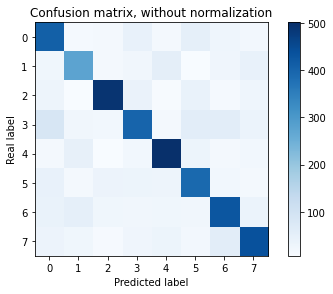

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_val, X_val)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, class_names)

In [ ]:
file = open(data_dir_drive + "mySubmission3.txt","w+") 
file.write("id,label\n")

for i in range(35001, 40001):
    img = Image.open(data_dir_drive + 'data/test/0' + str(i) + '.png')
    img = transform_test(img)
    img = Variable(img)
    img = img.unsqueeze(0)
    output = net(img) #I pass the whole test folder to the network image-by-image
    _, predicted = output.max(1)
    file.write('0' + str(i) + '.png,' + str(int(predicted[0])) +'\n')

file.close()

In [ ]:
! ls '/content/gdrive/My Drive/Colab Notebooks/Deep'

data	  E1.ipynb  mySubmission2.txt  mySubmission.txt
data.zip  models    mySubmission3.txt  test.zip
